In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

/Users/hangyojeong/miniforge3/envs/m1_tf_keras/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Metal device set to: Apple M1


2022-12-21 19:44:27.375003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-21 19:44:27.375269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

마지막 3개의 합성곱 층을 미세 조정

block5_conv1, block5_conv2, block5_conv3 층 학습 대상 나머지는 모든 층은 동결

더 많은 층을 미세 조정 하지 않는 이유?
- 합성곱 기반 층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩, 반면 상위 층은 좀 더 특화된 특성을 인코딩.
    - 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적 특성이므로 이들을 미세 조정하는 것이 유리
    - 하위 층으로 갈수록 미세 조정에 대한 효과가 감소
- 훈련해야 할 파라미터가 많을 수록 과대적합의 위험이 커짐

In [4]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dogs-vs-cats/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   shear_range = 0.1, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest')

# 검증 데이터는 증식되어선 안됨
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150,150), 
                                                    batch_size=20, 
                                                    class_mode='binary')
validation_generator = train_datagen.flow_from_directory(validation_dir, 
                                                    target_size=(150,150), 
                                                    batch_size=20, 
                                                    class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/Users/hangyojeong/miniforge3/envs/m1_tf_keras/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/rz/96n_vjq17kg53f0rgc21grc40000gn/T/ipykernel_973/2639404750.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2022-12-21 19:56:20.700556: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-21 19:56:20.969862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.4596 - acc: 0.7950

2022-12-21 19:56:41.737471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 29s 277ms/step - loss: 0.4596 - acc: 0.7950 - val_loss: 0.3266 - val_acc: 0.8760
Epoch 2/30
100/100 [==============================] - 27s 273ms/step - loss: 0.2829 - acc: 0.8855 - val_loss: 0.2555 - val_acc: 0.8880
Epoch 3/30
100/100 [==============================] - 27s 273ms/step - loss: 0.2288 - acc: 0.9070 - val_loss: 0.2491 - val_acc: 0.8880
Epoch 4/30
100/100 [==============================] - 27s 272ms/step - loss: 0.1970 - acc: 0.9220 - val_loss: 0.2764 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 27s 272ms/step - loss: 0.1781 - acc: 0.9350 - val_loss: 0.2077 - val_acc: 0.9140
Epoch 6/30
100/100 [==============================] - 27s 274ms/step - loss: 0.1655 - acc: 0.9280 - val_loss: 0.2056 - val_acc: 0.9190
Epoch 7/30
100/100 [==============================] - 27s 273ms/step - loss: 0.1578 - acc: 0.9425 - val_loss: 0.1926 - val_acc: 0.9200
Epoch 8/30
100/100 [==============================] - 27s 273ms/st

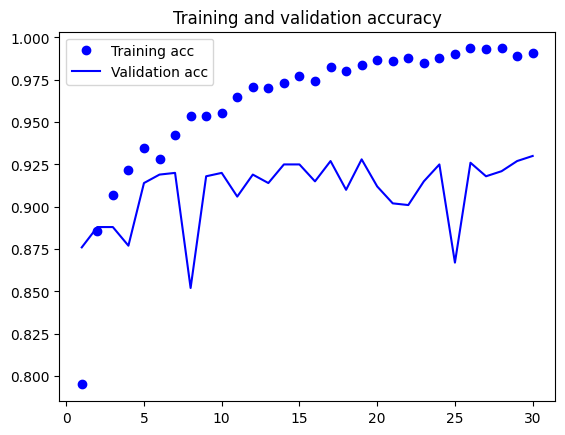

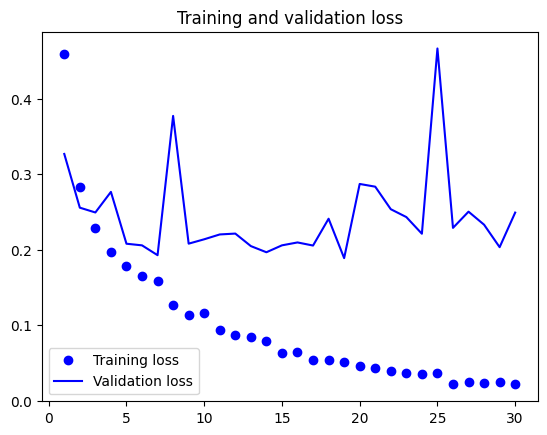

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

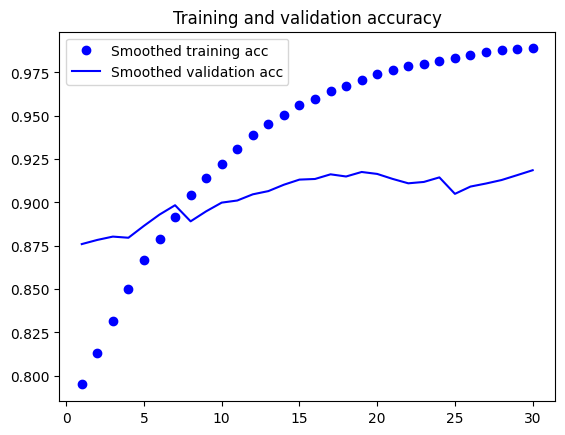

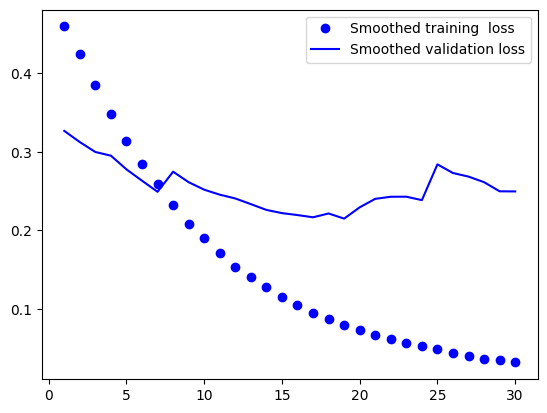

In [10]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training  loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.legend()

plt.show()

In [11]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150,150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/var/folders/rz/96n_vjq17kg53f0rgc21grc40000gn/T/ipykernel_973/2269266159.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9420000314712524
